In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [19]:
merged_data = pd.read_csv('../data/cleaned_merged_data.csv')

C:\Users\Nah\AppData\Local\Temp\ipykernel_18820\2810886917.py:1: DtypeWarning: Columns (4,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv('../data/cleaned_merged_data.csv')


In [20]:
merged_data['price_per_unit'] = merged_data['price_per_unit'].fillna(0)  # Replace NaN with 0

merged_data['discount'] = np.where(
    merged_data['old_price'] > 0,
    (merged_data['old_price'] - merged_data['current_price']) / merged_data['old_price'] * 100,
    np.nan 
)

merged_data = merged_data.dropna(subset=['discount'])
merged_data = merged_data[merged_data['discount'] >= 0]

vendor_summary = merged_data.groupby('vendor').agg(
avg_current_price=('current_price', 'mean'),
avg_old_price=('old_price', 'mean'),
avg_discount=('discount', 'mean'),
avg_price_per_unit=('price_per_unit', 'mean'),
product_count=('product_name', 'nunique')
).reset_index()

print("\nVendor Summary:")
print(vendor_summary)


Vendor Summary:
        vendor  avg_current_price  avg_old_price  avg_discount  \
0     Galleria          13.512831      17.598031     22.830961   
1      Loblaws           7.721750       9.111551     16.284255   
2        Metro           6.099827       7.388515     17.444325   
3     NoFrills           4.669489       5.814155     19.303556   
4  SaveOnFoods           5.946735       7.541938     22.189494   
5        TandT           8.443238      11.067435     26.889243   
6        Voila           5.536543       6.848010     19.947920   
7      Walmart           6.333849      13.372232     27.890747   

   avg_price_per_unit  product_count  
0            0.000000            229  
1            5.940934           7961  
2            2.584608          11551  
3            2.065224           7162  
4            2.658080           8251  
5            0.000000           3470  
6            2.424214           8387  
7           25.612072           6024  


C:\Users\Nah\AppData\Local\Temp\ipykernel_18820\37671656.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data, x='vendor', y='current_price', palette='muted')


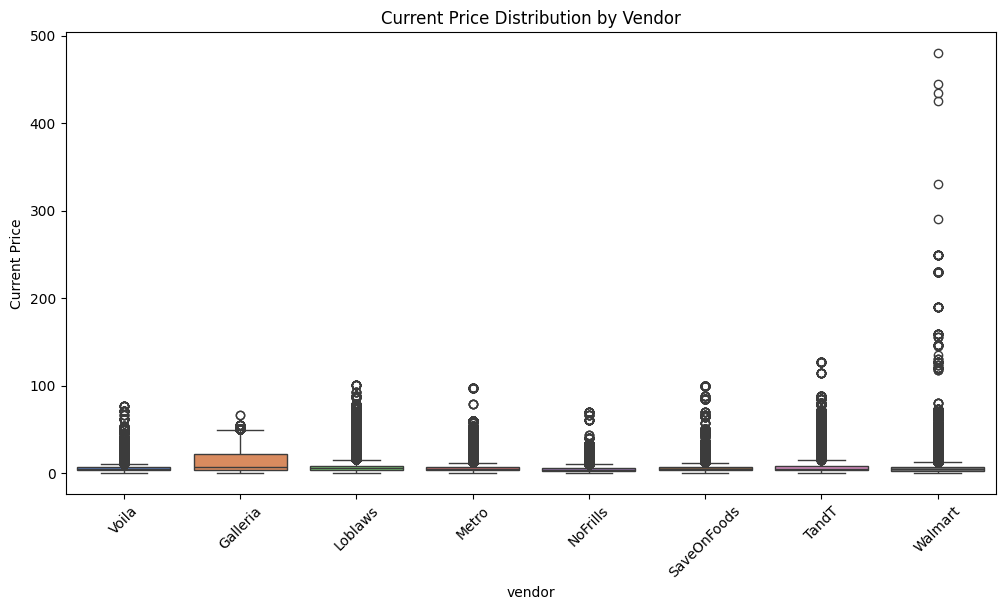

C:\Users\Nah\AppData\Local\Temp\ipykernel_18820\37671656.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data, x='vendor', y='price_per_unit', palette='muted')


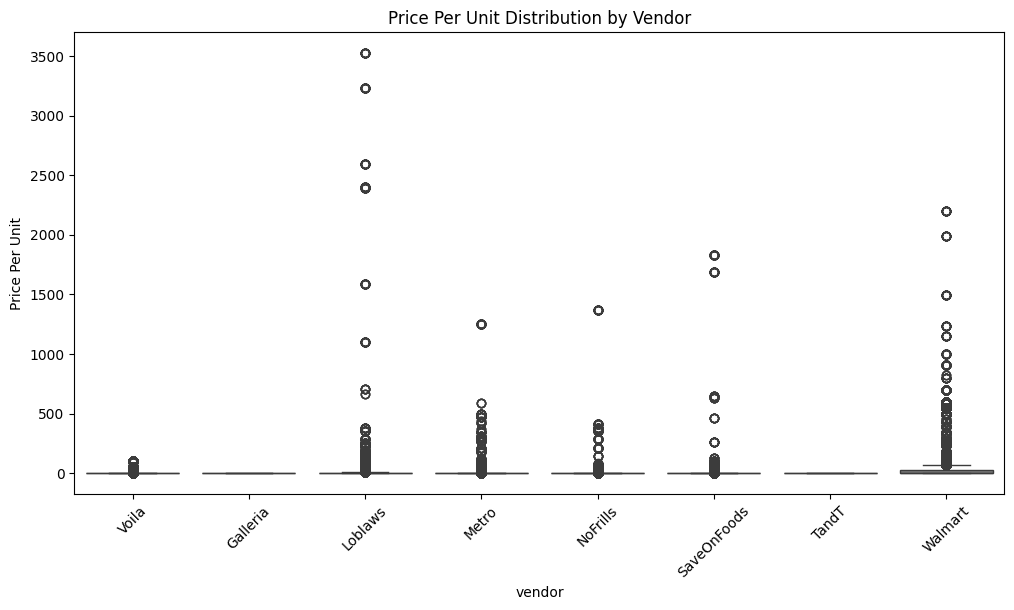

C:\Users\Nah\AppData\Local\Temp\ipykernel_18820\37671656.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data, x='vendor', y='discount', palette='muted')


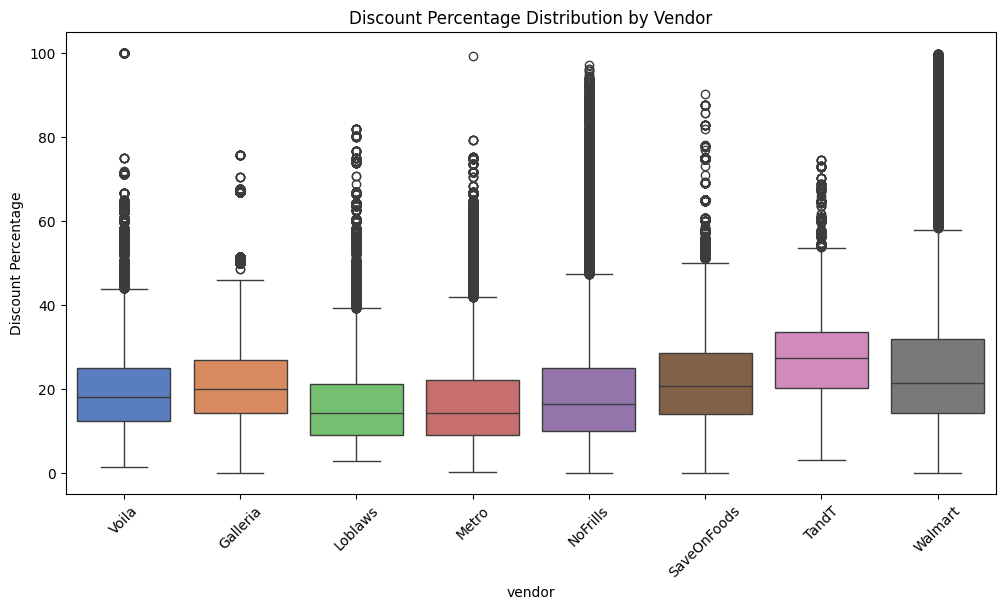

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='vendor', y='current_price', palette='muted')
plt.title('Current Price Distribution by Vendor')
plt.xticks(rotation=45)
plt.ylabel('Current Price')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='vendor', y='price_per_unit', palette='muted')
plt.title('Price Per Unit Distribution by Vendor')
plt.xticks(rotation=45)
plt.ylabel('Price Per Unit')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='vendor', y='discount', palette='muted')
plt.title('Discount Percentage Distribution by Vendor')
plt.xticks(rotation=45)
plt.ylabel('Discount Percentage')
plt.show()

In [22]:
median_price = vendor_summary['avg_current_price'].median()
print(f"Median current price across vendors: ${median_price:.2f}")

# top three vendors with the highest average discounts
top_discount_vendors = vendor_summary.sort_values(by='avg_discount', ascending=False).head(3)
print("\nTop 3 vendors with the highest average discounts:")
print(top_discount_vendors[['vendor', 'avg_discount']])

Median current price across vendors: $6.22

Top 3 vendors with the highest average discounts:
     vendor  avg_discount
7   Walmart     27.890747
5     TandT     26.889243
0  Galleria     22.830961


In [23]:
X = merged_data[['vendor']]
y = merged_data['discount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('vendor_ohe', OneHotEncoder(), ['vendor'])
        ],
        remainder='passthrough'
    )),
    ('regressor', RandomForestRegressor(random_state=42))
])

pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(pipeline, X, y, cv=5)
print(f'Cross-Validation MAE: {np.mean(cv_scores):.2f}')

y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')
r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared:.2f}')

Cross-Validation MAE: -0.16
Mean Absolute Error: 8.92
R-squared: 0.07


In [24]:
regressor = pipeline.named_steps['regressor']
feature_importances = regressor.feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(importance_df)

Feature Importance:
                          Feature  Importance
7      vendor_ohe__vendor_Walmart    0.484923
5        vendor_ohe__vendor_TandT    0.211464
4  vendor_ohe__vendor_SaveOnFoods    0.149975
6        vendor_ohe__vendor_Voila    0.051315
3     vendor_ohe__vendor_NoFrills    0.031949
2        vendor_ohe__vendor_Metro    0.028893
1      vendor_ohe__vendor_Loblaws    0.021866
0     vendor_ohe__vendor_Galleria    0.019615


            Actual  Predicted  Residuals
9070522  14.073495  22.177032  -8.103537
6476641  33.377837  17.447818  15.930020
5014873  11.771630  16.286010  -4.514380
8398418  16.694491  19.307881  -2.613390
6104710   8.347245  17.447818  -9.100572
4519214  37.656904  16.286010  21.370894
8791568  15.197568  22.177032  -6.979464
8977270  31.595577  22.177032   9.418545
2659249  11.782032  19.952486  -8.170454
9391426  14.966635  22.177032  -7.210397


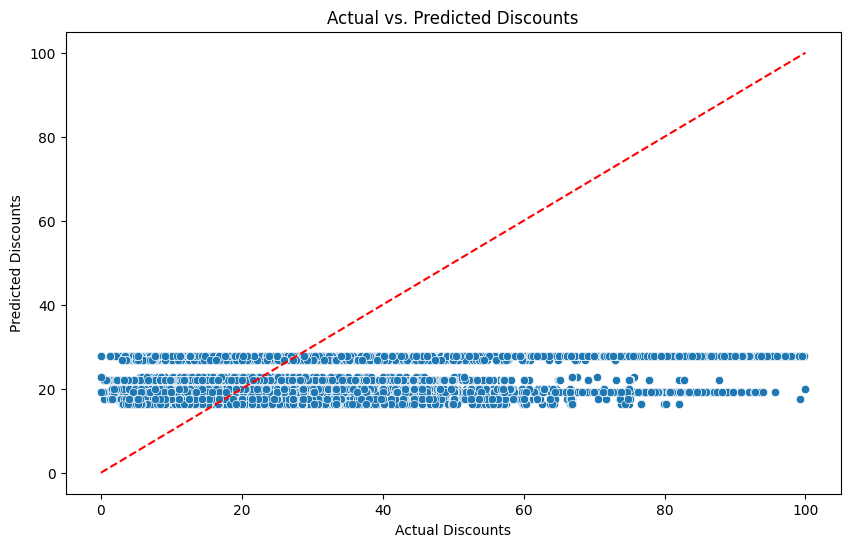

In [25]:
prediction_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
prediction_results['Residuals'] = prediction_results['Actual'] - prediction_results['Predicted']

print(prediction_results.head(10))

plt.figure(figsize=(10, 6))
sns.scatterplot(data=prediction_results, x='Actual', y='Predicted')
plt.plot([prediction_results['Actual'].min(), prediction_results['Actual'].max()],
         [prediction_results['Actual'].min(), prediction_results['Actual'].max()],
         color='red', linestyle='--')  # Line of equality
plt.title('Actual vs. Predicted Discounts')
plt.xlabel('Actual Discounts')
plt.ylabel('Predicted Discounts')
plt.show()

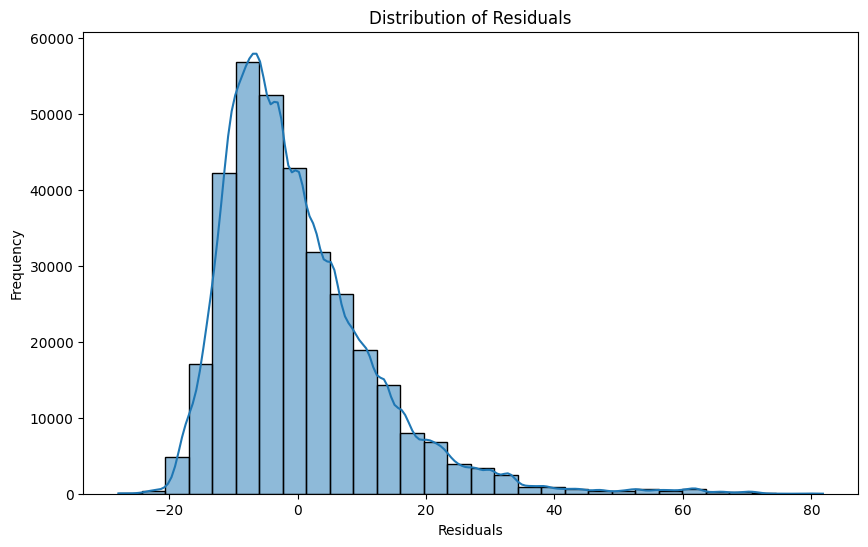

C:\Users\Nah\AppData\Local\Temp\ipykernel_18820\2416337934.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vendor_results = prediction_results[X['vendor'] == vendor]


Mean Absolute Error for Voila: 8.04
Mean Absolute Error for Galleria: 9.67


C:\Users\Nah\AppData\Local\Temp\ipykernel_18820\2416337934.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vendor_results = prediction_results[X['vendor'] == vendor]
C:\Users\Nah\AppData\Local\Temp\ipykernel_18820\2416337934.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vendor_results = prediction_results[X['vendor'] == vendor]


Mean Absolute Error for Loblaws: 7.46
Mean Absolute Error for Metro: 8.63
Mean Absolute Error for NoFrills: 9.50


C:\Users\Nah\AppData\Local\Temp\ipykernel_18820\2416337934.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vendor_results = prediction_results[X['vendor'] == vendor]
C:\Users\Nah\AppData\Local\Temp\ipykernel_18820\2416337934.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vendor_results = prediction_results[X['vendor'] == vendor]
C:\Users\Nah\AppData\Local\Temp\ipykernel_18820\2416337934.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vendor_results = prediction_results[X['vendor'] == vendor]


Mean Absolute Error for SaveOnFoods: 8.94
Mean Absolute Error for TandT: 8.10
Mean Absolute Error for Walmart: 14.43


C:\Users\Nah\AppData\Local\Temp\ipykernel_18820\2416337934.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vendor_results = prediction_results[X['vendor'] == vendor]
C:\Users\Nah\AppData\Local\Temp\ipykernel_18820\2416337934.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vendor_results = prediction_results[X['vendor'] == vendor]


In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(prediction_results['Residuals'], bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

for vendor in X['vendor'].unique():
    vendor_results = prediction_results[X['vendor'] == vendor]
    mae_vendor = mean_absolute_error(vendor_results['Actual'], vendor_results['Predicted'])
    print(f'Mean Absolute Error for {vendor}: {mae_vendor:.2f}')